In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [19]:
# Configuración general
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# =======================================
# 1. Cargar y preparar datos
# =======================================
parametro = 'ozono' 
ruta = f'Datasets/Datos_SIATA_Aire_{parametro}.json'

df = pd.read_json(ruta)

# ===========================
# 2. Expandir la columna "datos"
# ===========================
df_expandido = pd.concat([
    pd.DataFrame(estacion['datos']).assign(
        estacion=estacion['nombre'],
        nombre_corto=estacion['nombreCorto']
    )
    for _, estacion in df.iterrows()
])


In [20]:
# ===========================
# 3. Limpieza y fechas
# ===========================
# Convertir a datetime
df_expandido['fecha'] = pd.to_datetime(df_expandido['fecha'], errors='coerce')
df_expandido = df_expandido.dropna(subset=['fecha'])

# Filtrar registros calibrados
df_expandido = df_expandido[df_expandido['valor'] != -9999]

# Convertir 'calidad' a numérico
df_expandido['calidad'] = pd.to_numeric(df_expandido['calidad'], errors='coerce')
df_expandido = df_expandido.dropna(subset=['calidad'])

# Extraer mes y año
df_expandido['mes'] = df_expandido['fecha'].dt.month
df_expandido['anio'] = df_expandido['fecha'].dt.year

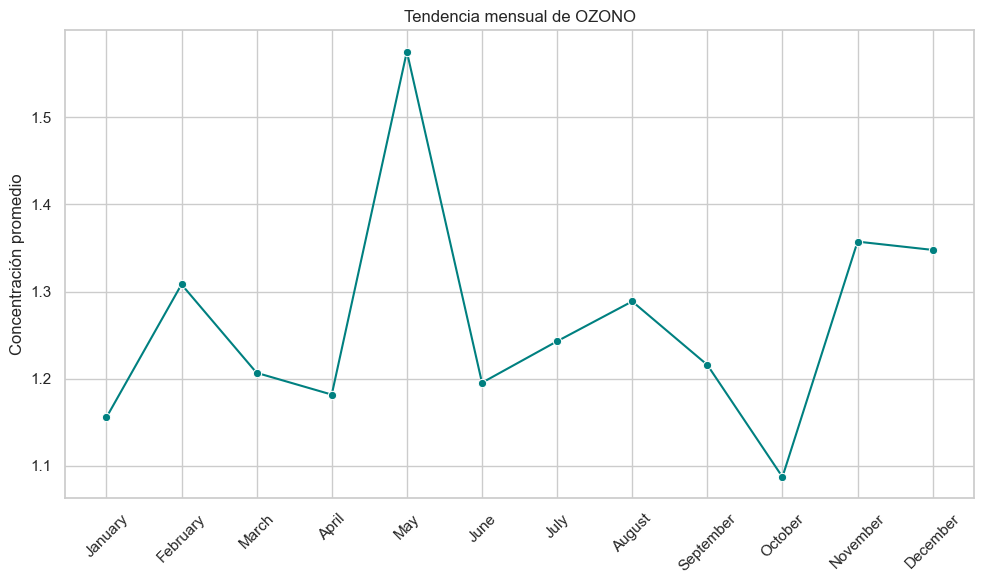

In [21]:
# ===========================
# 4. Tendencia mensual
# ===========================
prom_mensual = df_expandido.groupby('mes')['calidad'].mean().reindex(range(1, 13))
meses = [calendar.month_name[m] for m in prom_mensual.index]

plt.figure()
sns.lineplot(x=meses, y=prom_mensual.values, marker='o', color='teal')
plt.title(f'Tendencia mensual de {parametro.upper()}')
plt.ylabel('Concentración promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_6296\3040884008.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_estaciones.index, y=top_estaciones.values, palette='rocket')


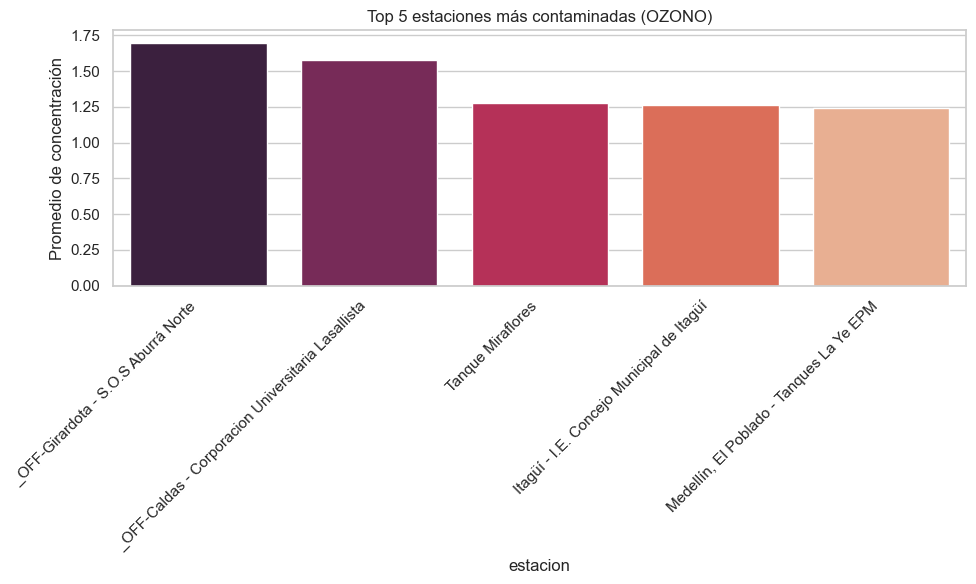

In [22]:
# ===========================
# 5. Top 5 estaciones más contaminadas
# ===========================
top_estaciones = df_expandido.groupby('estacion')['calidad'].mean().sort_values(ascending=False).head(5)

plt.figure()
sns.barplot(x=top_estaciones.index, y=top_estaciones.values, palette='rocket')
plt.title(f'Top 5 estaciones más contaminadas ({parametro.upper()})')
plt.ylabel('Promedio de concentración')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

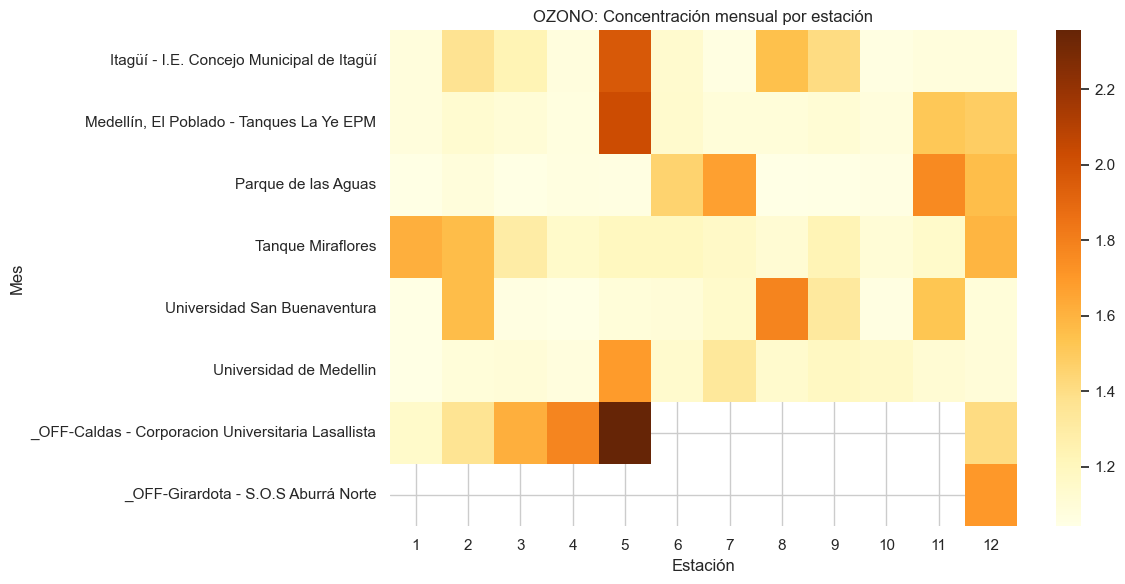

In [23]:
# ===========================
# 6. Mapa de calor mensual por estación
# ===========================
pivot = df_expandido.pivot_table(index='estacion', columns='mes', values='calidad', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrBr', annot=False)
plt.title(f'{parametro.upper()}: Concentración mensual por estación')
plt.ylabel('Mes')
plt.xlabel('Estación')
plt.tight_layout()
plt.show()

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_6296\2798983270.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_expandido, x='estacion', y='calidad', palette='Set3')


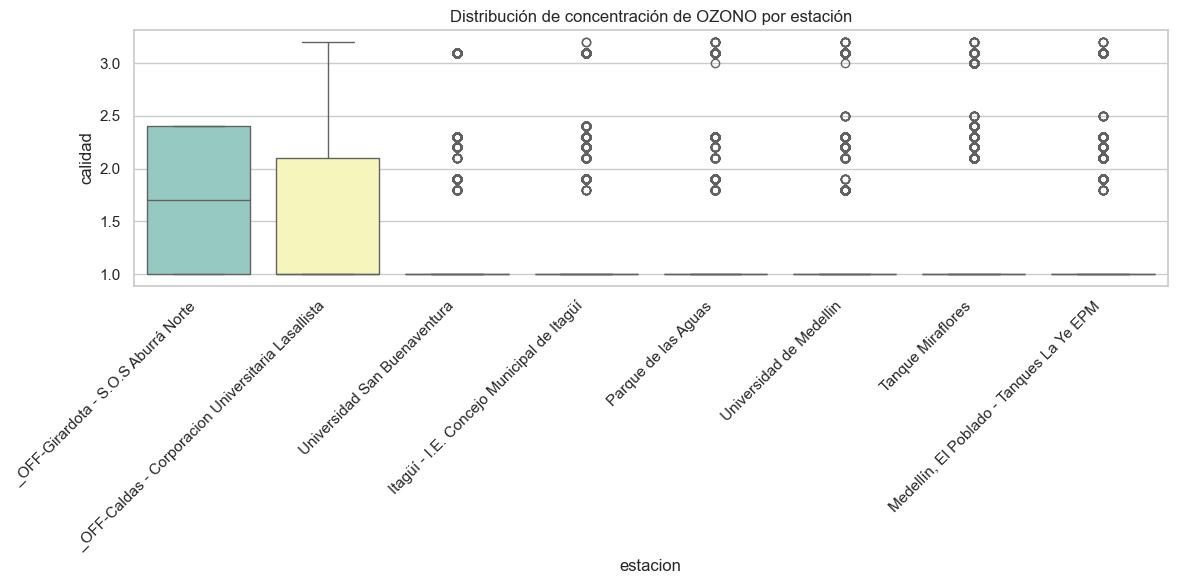

In [24]:
# ===========================
# 7. Distribución por estación
# ===========================
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_expandido, x='estacion', y='calidad', palette='Set3')
plt.title(f'Distribución de concentración de {parametro.upper()} por estación')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()